## Importando Bibliotecas

In [46]:
import os
import sys
import pandas as pd
import numpy as np

#Plots
import matplotlib.pyplot as plt
import seaborn as sns
import timeit
# `do not disturb` mode
import warnings                                  
warnings.filterwarnings('ignore')
                           
# Dates Manipulation
from dateutil.relativedelta import relativedelta 
from datetime import datetime, timedelta
import holidays
import calendar

# statistics
import statsmodels.formula.api as smf            
import statsmodels.tsa.api as smt
import statsmodels.api as sm

#Signal Processing
import scipy as sp
import scipy.fftpack
from scipy.optimize import minimize

In [47]:
%matplotlib inline
%config InlineBackend.figure_format = 'svg'

sns.set_style("darkgrid", {"axes.facecolor": ".9"})
sns.set_context("paper")

params = {'figure.figsize': [12, 6], 
          'axes.labelsize': 16,
          'axes.titlesize':18, 
          'font.size': 16,
          'legend.fontsize': 12, 
          'xtick.labelsize': 12, 
          'ytick.labelsize': 12
         }

plt.rcParams.update(params)


In [48]:
# Seta display de x linhas
pd.set_option('display.max_row', 100)
# Seta display de x colunas
pd.set_option('display.max_columns', 15)

## Funções e Configurações

In [49]:
#######  function [GRNN]=grnn_v1(p,t,spread) #######
def train_matrix(p, t, spread):
    #Cria Matriz de Treinamento: 
    
    # p -> Matriz contendo os vetores de entrada
    # t -> Matriz contendo os vetores de saída
    # spread -> valor do spread que será utilizado
    
    #Cria matriz com as matrizes de entrada p e t
    GRNN=np.zeros((1+t.shape[0]+p.shape[0],t.shape[1]))
    
    # Verifica o número de padrões utilizados no treinamento "n"
    if p.shape[1] == t.shape[1]: 
        # número de entradas do vetor de entrada "ne"
        GRNN[0,0]=p.shape[0]
        # número de saídas do vetor de saída "ns"
        GRNN[0,1]=t.shape[0]
        # Spread
        GRNN[0,2]=spread
        
        #vetores de entrada P
        GRNN[1:1+p.shape[0],:]=p
        #Vetores de saída T
        GRNN[1+p.shape[0]:1+p.shape[0]+t.shape[0],:]=t
    return GRNN;

### GRNN

In [50]:
####### Função que implementa a GRNN #######

def implementa_grnn(GRNN, X): 
    
    # GRNN - Saída da Função grnn_v1(p,t,spread) #
    # X    - Valor a ser aproximado #

    # Definição de ne, n
    sizep = [GRNN[0,0], GRNN.shape[1]] 
    
    # Definição de ns, n
    sizet = [GRNN[0,1], GRNN.shape[1]] 
    
    # Parâmetro spread
    spread = GRNN[0,2]

    
    p = GRNN[1:1+int(sizep[0]),:]
    t = GRNN[1+int(sizep[0]):1+int(sizep[0])+int(sizet[0]),:]

    c1 = np.zeros((int(sizep[0]),int(sizep[1])))
    c3 = np.zeros((1,int(sizep[1])))
    
    num = np.zeros((int(sizet[0]),int(sizet[1])))
    den = np.copy(c3)
    
    Y = np.zeros((int(sizet[0]),np.size(X,1)))
    A = np.zeros((int(sizep[0]),int(sizep[1])))

    if (p.shape[0] == X.shape[0]):
        for i in range(X.shape[1]):
            for k in range(int(sizep[0])):
                A[k,:] = X[k,i]*np.ones((1,int(sizep[1])))
            c1 = abs(A-p)**2
            # soma "MATRIZ"
            c2 = np.sqrt(c1.sum(axis=0)) 
            
    ########### Aqui é a GRNN ########### 

            for j in range(int(sizep[1])): 
                c3[0,j] = (1)*np.exp(-(0.8326*c2[j]/spread)**2)
                for k in range(int(sizet[0])):
                    num[k,j] = t[k,j]*c3[0,j]
                den[0,j] = c3[0,j]
                
    ########################################

            for k in range(int(sizet[0])):
                #Y(k,i)=sum(num(k,:)/(sum(den)+1e-9)
                Y[k,i]=(np.sum(num[k,:])/(np.sum(den)+0.0000000001))
    return Y

### GRNN Modificada

In [51]:
####### Função que implementa a GRNN Modificada #######

def implementa_grnn_mod(GRNN, X, nmax): 
    
    # GRNN - Saída da Função grnn_v1(p,t,spread) #
    # X    - Valor a ser aproximado #
    
    # Definição de ne, n
    sizep=[GRNN[0,0], GRNN.shape[1]]
    
    # Definição de ns, n
    sizet=[GRNN[0,1], GRNN.shape[1]] 
    
    # Parâmetro spread
    spread=GRNN[0,2]

    p=GRNN[1:1+int(sizep[0]),:]
    t=GRNN[1+int(sizep[0]):1+int(sizep[0])+int(sizet[0]),:]

    c1=np.zeros((int(sizep[0]),int(sizep[1])))
    c3=np.zeros((1,nmax))

    num=np.zeros((int(sizet[0]),int(sizet[1])))
    den=np.copy(c3)
    
    Y=np.zeros((int(sizet[0]), X.shape[1]))
    A=np.zeros((int(sizep[0]),int(sizep[1])))
    
    if (p.shape[0] == X.shape[0]):
        for i in range(X.shape[1]):      
            for k in range(int(sizep[0])):
                A[k,:]=X[k,i]*np.ones((1,int(sizep[1])))
            
            c1=abs(A-p)**2
            
            # soma "MATRIZ"
            c2=np.sqrt(c1.sum(axis=0))

########### Aqui é a GRNN modificada ###########
        
            ind_c2 = np.argsort(c2)
            ord_c2 = np.sort(c2)
        
            for j in range(nmax): 
                
                c3[0,j]=(1)*np.exp(-(0.8326*ord_c2[j]/spread)**2)
                
                for k in range(int(sizet[0])):
                    
                    num[k,j]=t[k,ind_c2[j]]*c3[0,j]
                    
                den[0,j]=c3[0,j]
                
####################################################
            
            for k in range(int(sizet[0])):
                Y[k,i]=(np.sum(num[k,:])/(np.sum(den)+0.0000000001))
    return Y

In [52]:
def teste_grnn(testes_input_1, out, columns_n, GRNN_com):

    for (i, j) in zip(testes_input_1, range(len(testes_input_1))):


        if(j==0):
            matriz = np.matrix(i.T)

            teste_x = pd.DataFrame(implementa_grnn(GRNN_com, matriz),\
                                   index = out.index, columns = out.columns)

            stats_d1 = load_statistics_2(ajeita_df(teste_x), 'data_med', 'carga')
            stats_d1.index = pd.DatetimeIndex(stats_d1.index) + pd.DateOffset(1)
            #print(j)
            #print(stats_d1)

            result = teste_x

        else:

            new_df = pd.concat([i, stats_d1], axis=1, join = 'inner')
            #print(new_df)
            matriz = np.matrix(new_df.T)

            teste_x = pd.DataFrame(implementa_grnn(GRNN_com, matriz),\
                                   index = out.index, columns = out.columns)

            df = ajeita_df(teste_x)
            stats_d1 = load_statistics_2(df, 'data_med', 'carga')
            stats_d1.index = pd.DatetimeIndex(stats_d1.index) + pd.DateOffset(j+1)

            #print(j)
            #print(stats_d1)

            result = pd.concat([result, teste_x], axis=1)

    result.columns = columns_n
    return result

### Avaliação de Desempenho

In [53]:
def mape(y_true, y_pred): 
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

In [54]:
def emax(y_true, y_pred): 
    return np.max(np.abs((y_true - y_pred) / y_true)) * 100

### Pré Processamento

In [55]:
## Filtra os datasets para o ano de 2018
def filteryear(df):
    df = df[(df['year']) == 2018]
    return df

In [56]:
#Normaliza os valorews de carga

def normalize(df, new_column, column):
    df[new_column] = df[column]/max(df[column])

In [57]:
def extract_time(df):
    df['time'] = df['data_medicao'].dt.time

In [58]:
## Pega o mês de Referência

def get_month(df):
    df['inp_month'] = df['month']/12

In [59]:
## Pega o mês de Referência - Perídodo Cíclico

def get_month_saw(df):
    if df['month'] == 1:
        return 0.8333
    elif df['month'] == 2:
        return 0.6667
    elif df['month'] == 3:
        return 0.5000
    elif df['month'] == 4:
        return 0.3333
    elif df['month'] == 5:
        return 0.1667
    elif df['month'] == 6:
        return 0
    elif df['month'] == 7:
        return 0.1667
    elif df['month'] == 8:
        return 0.3333
    elif df['month'] == 9:
        return 0.5000
    elif df['month'] == 10:
        return 0.6667
    elif df['month'] == 11:
        return 0.8333
    else:
        return 1

In [60]:
def month_saw(df):
     df['inp_month'] = df.apply (lambda row: get_month_saw(row), axis=1)

In [61]:
## Pega dummies para os dias da semana

def getmon(df):
    
    if df['week_day'] == 'MONDAY' :
        return 1
    else :
        return 0
    
def gettue_res(df):    
    if df['week_day'] == 'TUESDAY' :
        return 1
    else :
        return 0
    
def getwed_res(df):    
    if df['week_day'] == 'WEDNESDAY' :
        return 1
    else :
        return 0

def getthu_res(df):       
    if df['week_day'] == 'THURSDAY' :
        return 1
    else :
        return 0
    
def getfri_res(df):       
    if df['week_day'] == 'FRIDAY' :
        return 1
    else :
        return 0
    
def getsat(df):       
    if df['week_day'] == 'SATURDAY' :
        return 1
    else :
        return 0
    
def getsun(df):           
    if df['week_day'] == 'SUNDAY' :
        return 1
    else :
        return 0

In [62]:
def residential_stats(df):
    df['is_monday'] = df.apply (lambda row: getmon(row), axis=1)

    df['is_tuesday'] = df.apply (lambda row: gettue_res(row), axis=1)

    df['is_wednesday'] = df.apply (lambda row: getwed_res(row), axis=1)
    
    df['is_thursday'] = df.apply (lambda row: getthu_res(row), axis=1)
    
    df['is_friday'] = df.apply (lambda row: getfri_res(row), axis=1)
    
    df['is_saturday'] = df.apply (lambda row: getsat(row), axis=1)
    
    df['is_sunday'] = df.apply (lambda row: getsun(row), axis=1)

In [63]:
def load_statistics(df, column1, column2):
    
    # Input: df receives dataframe and column receives string

    result = df.groupby(column1)[column2].agg(['min','max','mean'])
    shift_df = result.shift(periods=1, fill_value=0).reset_index()

    return shift_df

In [64]:
def load_statistics_2(df, column1, column2):
    
    # Input: df receives dataframe and column receives string

    result = df.groupby(column1)[column2].agg(['min','max','mean'])

    return result

In [65]:
def ajeita_df(df):
    
    columns = ['time', 'data_med', 'carga']
    
    df1 = df.stack().reset_index()
    df1.columns = columns
    df1['data_medicao'] = pd.to_datetime(df1['data_med'])  + pd.to_timedelta(df1['time'].astype(str))
    df1 = df1.drop(columns=['time'])
    df1 = df1.sort_values(by = 'data_medicao').reset_index(drop = True)
    
    return df1

In [66]:
def peso_feriado(df, n):
    df['feriado'] = n*df['feriado']

In [67]:
def peso_carga(df, n):
    df['valor_kwh_n'] = n*df['valor_kwh_n']

## Importando os Datasets

In [68]:
%%time
# Definindo os nomes das colunas
typing = {'instalacao': 'str'}

#importando o arquivo - Dataset de dados de carga Comerciais
data_com = pd.read_csv(r'C:/Users/vitmi/Desktop/TCC/Data/load_data/Data_res_mean.csv', encoding='utf-8', 
                       sep = ';', decimal = '.',  dtype = typing, parse_dates = ['data_medicao'])

data_com = filteryear(data_com)
month_saw(data_com)
extract_time(data_com)
max_comercial = max(data_com['valor_kwh'])
normalize(data_com, 'valor_kwh_n', 'valor_kwh')

Wall time: 8.11 s


In [69]:
peso_feriado(data_com, 4)
peso_carga(data_com, 1)

## Pré Processamento

In [70]:
data_com_group = pd.DataFrame(data_com.groupby(by = ['data_med', 'inp_month', 'hora_verao', 'feriado', 'week_day'])\
                                 ['valor_kwh'].mean()).reset_index(drop = False)
residential_stats(data_com_group)
data_com_group = data_com_group.drop(columns=['data_med', 'valor_kwh', 'week_day'])

In [71]:
data_com_stats = load_statistics(data_com, 'data_med', 'valor_kwh_n')

### Matriz de entrada X

In [72]:
data_mod_com = pd.concat([data_com_group, data_com_stats], axis=1, join="inner").set_index(['data_med'])

#### Treino, Validação e Teste 

In [73]:
### Entrada Comercial - Treino
data_mod_com_tre = data_mod_com.loc['2018-01-01':'2018-11-30']
data_mod_com_tre_m = np.matrix(data_mod_com_tre.T)

In [74]:
#Entrada Comercial - Validação 
data_mod_com_val = data_mod_com.loc['2018-12-01':'2018-12-07']
data_mod_com_val_m = np.matrix(data_mod_com_val.T)

In [75]:
### Entrada Comercial - Teste
data_mod_com_teste1 = data_mod_com.loc['2018-12-08':'2018-12-14']
data_mod_com_teste2 = data_mod_com.loc['2018-12-22':'2018-12-28']

In [76]:
data_mod_com_teste1_08 = pd.DataFrame(data_mod_com_teste1.loc['2018-12-08']).T
data_mod_com_teste1_09 = pd.DataFrame(data_mod_com_teste1.loc['2018-12-09']).T
data_mod_com_teste1_10 = pd.DataFrame(data_mod_com_teste1.loc['2018-12-10']).T
data_mod_com_teste1_11 = pd.DataFrame(data_mod_com_teste1.loc['2018-12-11']).T
data_mod_com_teste1_12 = pd.DataFrame(data_mod_com_teste1.loc['2018-12-12']).T
data_mod_com_teste1_13 = pd.DataFrame(data_mod_com_teste1.loc['2018-12-13']).T
data_mod_com_teste1_14 = pd.DataFrame(data_mod_com_teste1.loc['2018-12-14']).T

In [77]:
data_mod_com_teste2_22 = pd.DataFrame(data_mod_com_teste2.loc['2018-12-22']).T
data_mod_com_teste2_23 = pd.DataFrame(data_mod_com_teste2.loc['2018-12-23']).T
data_mod_com_teste2_24 = pd.DataFrame(data_mod_com_teste2.loc['2018-12-24']).T
data_mod_com_teste2_25 = pd.DataFrame(data_mod_com_teste2.loc['2018-12-25']).T
data_mod_com_teste2_26 = pd.DataFrame(data_mod_com_teste2.loc['2018-12-26']).T
data_mod_com_teste2_27 = pd.DataFrame(data_mod_com_teste2.loc['2018-12-27']).T
data_mod_com_teste2_28 = pd.DataFrame(data_mod_com_teste2.loc['2018-12-28']).T

In [78]:
testes_1 = [data_mod_com_teste1_09, data_mod_com_teste1_10, data_mod_com_teste1_11,\
            data_mod_com_teste1_12, data_mod_com_teste1_13, data_mod_com_teste1_14]

testes_2 = [data_mod_com_teste2_23, data_mod_com_teste2_24, data_mod_com_teste2_25,\
            data_mod_com_teste2_26, data_mod_com_teste2_27, data_mod_com_teste2_28]

In [79]:
for k in testes_1:
    k.drop(columns=['min', 'max', 'mean'], inplace = True)
    
for k in testes_2:
    k.drop(columns=['min', 'max', 'mean'], inplace = True)

### Matriz de Saída Y

In [80]:
data_out_com = pd.pivot_table(data_com, values = 'valor_kwh_n', columns='data_med', index = 'time')

#### Treino, Validação e Teste 

In [81]:
### Saída Comercial - Entrada
data_out_com_tre = data_out_com.T.loc['2018-01-01':'2018-11-30'].T
data_out_com_tre_m = np.matrix(data_out_com_tre)

In [82]:
### Saída Comercial - Validação
data_out_com_val = data_out_com.T.loc['2018-12-01':'2018-12-07'].T

In [83]:
### Saída Comercial - Teste
data_out_com_teste1 = data_out_com.T.loc['2018-12-08':'2018-12-14'].T
data_out_com_teste2 = data_out_com.T.loc['2018-12-22':'2018-12-28'].T

In [84]:
data_out_com_teste1_08 = pd.DataFrame(data_out_com_teste1['2018-12-08'])
out1 = data_out_com_teste1_08

data_out_com_teste2_22 = pd.DataFrame(data_out_com_teste2['2018-12-22'])
out2 = data_out_com_teste2_22

## GRNN - Modelo Comercial

In [85]:
spread = list(np.arange(100, 10000, 50) / 10000)
spread_min = 100

MAPE_MIN_a = np.zeros(np.size(spread))
MAPE_MIN = 100

EMAX_MIN_a = np.zeros(np.size(spread))
EMAX_MIN = 100

for (i,j) in zip(spread, range(np.size(spread))):

    GRNN_com = train_matrix(data_mod_com_tre_m, data_out_com_tre_m, i)

    x = pd.DataFrame(implementa_grnn(GRNN_com, data_mod_com_val_m),\
                      index = data_out_com_val.index, columns = data_out_com_val.columns)

    df1 = ajeita_df(x)
    df2 = ajeita_df(data_out_com_val)

    MAPE_MIN_a[j] = mape(df2['carga'], df1['carga'])
    EMAX_MIN_a[j] = emax(df2['carga'], df1['carga'])

    if(MAPE_MIN_a[j] < MAPE_MIN or EMAX_MIN_a[j] < EMAX_MIN ):
        MAPE_MIN = MAPE_MIN_a[j]
        EMAX_MIN = EMAX_MIN_a[j]
        spread_min = i

In [86]:
spread_min

0.935

In [87]:
%%time
GRNN_com = train_matrix(data_mod_com_tre_m, data_out_com_tre_m, 0.7)
 

Wall time: 1 ms


In [88]:
%%time
x = pd.DataFrame(implementa_grnn(GRNN_com, data_mod_com_val_m),\
                  index = data_out_com_val.index, columns = data_out_com_val.columns)

Wall time: 74 ms


In [91]:
start = timeit.default_timer()
x = pd.DataFrame(implementa_grnn(GRNN_com, data_mod_com_val_m),\
                  index = data_out_com_val.index, columns = data_out_com_val.columns)
stop = timeit.default_timer()
print('Time: {:0.2f} \n'.format((stop - start)*1000) )

Time: 74.63 



In [92]:


df1 = ajeita_df(x)
df2 = ajeita_df(data_out_com_val)

df1['carga_real'] = df1['carga']*max_comercial
df2['carga_real'] = df2['carga']*max_comercial

MAPE_tre = mape(df2['carga'], df1['carga'])
EMAX_tre = emax(df2['carga'], df1['carga'])

In [93]:
df1_val_1 = df1[(df1['data_med'] == '2018-12-01')]
df1_val_2 = df1[(df1['data_med'] == '2018-12-02')]
df1_val_3 = df1[(df1['data_med'] == '2018-12-03')]
df1_val_4 = df1[(df1['data_med'] == '2018-12-04')]
df1_val_5 = df1[(df1['data_med'] == '2018-12-05')]
df1_val_6 = df1[(df1['data_med'] == '2018-12-06')]
df1_val_7 = df1[(df1['data_med'] == '2018-12-07')]

df2_val_1 = df2[(df2['data_med'] == '2018-12-01')]
df2_val_2 = df2[(df2['data_med'] == '2018-12-02')]
df2_val_3 = df2[(df2['data_med'] == '2018-12-03')]
df2_val_4 = df2[(df2['data_med'] == '2018-12-04')]
df2_val_5 = df2[(df2['data_med'] == '2018-12-05')]
df2_val_6 = df2[(df2['data_med'] == '2018-12-06')]
df2_val_7 = df2[(df2['data_med'] == '2018-12-07')]

mape_val_1 = mape(df2_val_1['carga_real'], df1_val_1['carga_real'])
mape_val_2 = mape(df2_val_2['carga_real'], df1_val_2['carga_real'])
mape_val_3 = mape(df2_val_3['carga_real'], df1_val_3['carga_real'])
mape_val_4 = mape(df2_val_4['carga_real'], df1_val_4['carga_real'])
mape_val_5 = mape(df2_val_5['carga_real'], df1_val_5['carga_real'])
mape_val_6 = mape(df2_val_6['carga_real'], df1_val_6['carga_real'])
mape_val_7 = mape(df2_val_7['carga_real'], df1_val_7['carga_real'])

print('MAPES GRNN: \n') 
print('{:0.2f}'.format(mape_val_1)) 
print('{:0.2f}'.format(mape_val_2)) 
print('{:0.2f}'.format(mape_val_3)) 
print('{:0.2f}'.format(mape_val_4)) 
print('{:0.2f}'.format(mape_val_5)) 
print('{:0.2f}'.format(mape_val_6)) 
print('{:0.2f}'.format(mape_val_7)) 

MAPES GRNN: 

126.93
136.19
154.91
105.43
173.91
115.17
93.79


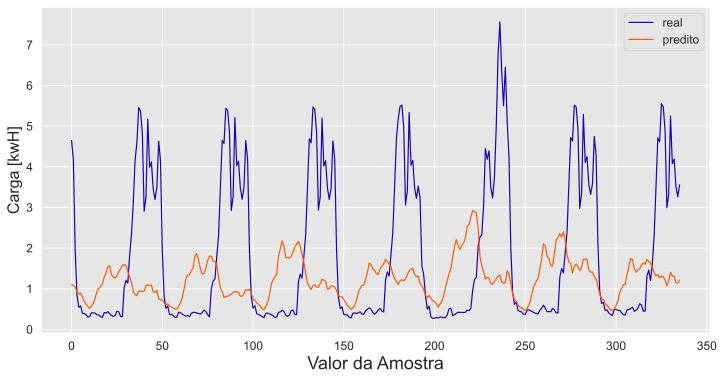

In [94]:
fig = plt.figure()

sns.lineplot(data = df2, x=df2.index, y="carga_real", label = 'real', color = 'xkcd:ultramarine')
sns.lineplot(data = df1, x=df1.index, y="carga_real",  label = 'predito', color = 'xkcd:bright orange')

# fig.suptitle('Consumo Registrado - Perfil Residencial', fontsize=20)
plt.xlabel('Valor da Amostra', fontsize=18)
plt.ylabel('Carga [kwH]', fontsize=16)
fig.savefig('C:/Users/vitmi/Desktop/TCC/Imagens/Resultados_res/tr_Consumo_res.png')

### Teste - GRNN Convencional - Modelo Comercial

In [95]:
columns_n_1 = ['2018-12-08', '2018-12-09', '2018-12-10', '2018-12-11', '2018-12-12', '2018-12-13', '2018-12-14'] 
columns_n_2 = ['2018-12-22', '2018-12-23', '2018-12-24', '2018-12-25', '2018-12-26', '2018-12-27', '2018-12-28'] 

In [96]:
testes_input_1 = [data_mod_com_teste1_08, data_mod_com_teste1_09, data_mod_com_teste1_10,\
                  data_mod_com_teste1_11, data_mod_com_teste1_12, data_mod_com_teste1_13,\
                  data_mod_com_teste1_14]

testes_input_2 = [data_mod_com_teste2_22, data_mod_com_teste2_23, data_mod_com_teste2_24,\
                  data_mod_com_teste2_25, data_mod_com_teste2_26, data_mod_com_teste2_27,\
                  data_mod_com_teste2_28]

### Resultados - Testes

In [97]:
%%time
result_teste1 = teste_grnn(testes_input_1, out1, columns_n_1, GRNN_com)

Wall time: 121 ms


In [98]:
df_pred_teste1 = ajeita_df(result_teste1)
df_out_teste1 = ajeita_df(data_out_com_teste1)


df_pred_teste1['carga_real'] = df_pred_teste1['carga']*max_comercial
df_out_teste1['carga_real'] = df_out_teste1['carga']*max_comercial


MAPE_te1 = mape(df_pred_teste1['carga'], df_out_teste1['carga'])
EMAX_te1 = emax(df_pred_teste1['carga'], df_out_teste1['carga'])

In [99]:
df1_val_8  = df_pred_teste1[(df_pred_teste1['data_med'] == '2018-12-08')]
df1_val_9  = df_pred_teste1[(df_pred_teste1['data_med'] == '2018-12-09')]
df1_val_10 = df_pred_teste1[(df_pred_teste1['data_med'] == '2018-12-10')]
df1_val_11 = df_pred_teste1[(df_pred_teste1['data_med'] == '2018-12-11')]
df1_val_12 = df_pred_teste1[(df_pred_teste1['data_med'] == '2018-12-12')]
df1_val_13 = df_pred_teste1[(df_pred_teste1['data_med'] == '2018-12-13')]
df1_val_14 = df_pred_teste1[(df_pred_teste1['data_med'] == '2018-12-14')]

df2_val_8  = df_out_teste1[(df_out_teste1['data_med'] == '2018-12-08')]
df2_val_9  = df_out_teste1[(df_out_teste1['data_med'] == '2018-12-09')]
df2_val_10 = df_out_teste1[(df_out_teste1['data_med'] == '2018-12-10')]
df2_val_11 = df_out_teste1[(df_out_teste1['data_med'] == '2018-12-11')]
df2_val_12 = df_out_teste1[(df_out_teste1['data_med'] == '2018-12-12')]
df2_val_13 = df_out_teste1[(df_out_teste1['data_med'] == '2018-12-13')]
df2_val_14 = df_out_teste1[(df_out_teste1['data_med'] == '2018-12-14')]

mape_val_8  = mape(df2_val_8 ['carga_real'], df1_val_8 ['carga_real'])
mape_val_9  = mape(df2_val_9 ['carga_real'], df1_val_9 ['carga_real'])
mape_val_10 = mape(df2_val_10['carga_real'], df1_val_10['carga_real'])
mape_val_11 = mape(df2_val_11['carga_real'], df1_val_11['carga_real'])
mape_val_12 = mape(df2_val_12['carga_real'], df1_val_12['carga_real'])
mape_val_13 = mape(df2_val_13['carga_real'], df1_val_13['carga_real'])
mape_val_14 = mape(df2_val_14['carga_real'], df1_val_14['carga_real'])

print('MAPES GRNN: \n') 
print('{:0.2f}'.format(mape_val_8)) 
print('{:0.2f}'.format(mape_val_9)) 
print('{:0.2f}'.format(mape_val_10)) 
print('{:0.2f}'.format(mape_val_11)) 
print('{:0.2f}'.format(mape_val_12)) 
print('{:0.2f}'.format(mape_val_13)) 
print('{:0.2f}'.format(mape_val_14)) 

MAPES GRNN: 

112.04
110.43
132.09
100.07
131.86
125.10
74.36


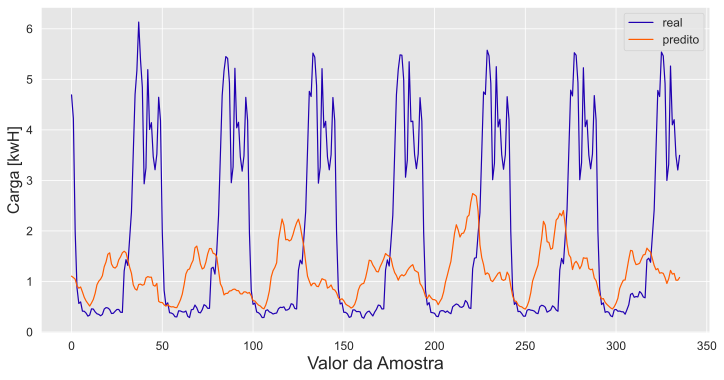

In [100]:
fig = plt.figure()

sns.lineplot(data = df_out_teste1, x=df_out_teste1.index, y="carga_real", label = 'real', color = 'xkcd:ultramarine')
sns.lineplot(data = df_pred_teste1, x=df_pred_teste1.index, y="carga_real",  label = 'predito', color = 'xkcd:bright orange')

# fig.suptitle('Consumo Registrado - Perfil Residencial', fontsize=20)
plt.xlabel('Valor da Amostra', fontsize=18)
plt.ylabel('Carga [kwH]', fontsize=16)
fig.savefig('C:/Users/vitmi/Desktop/TCC/Imagens/Resultados_res/pred1_Consumo_res.png')

In [101]:
%%time
result_teste2 = teste_grnn(testes_input_2, out2, columns_n_2, GRNN_com)

Wall time: 120 ms


In [102]:
df_pred_teste2 = ajeita_df(result_teste2)
df_out_teste2 = ajeita_df(data_out_com_teste2)

df_pred_teste2['carga_real'] = df_pred_teste2['carga']*max_comercial
df_out_teste2['carga_real'] = df_out_teste2['carga']*max_comercial

MAPE_te2 = mape(df_pred_teste2['carga'], df_out_teste2['carga'])
EMAX_te2 = emax(df_pred_teste2['carga'], df_out_teste2['carga'])

In [103]:
df1_val_22 = df_pred_teste2[(df_pred_teste2['data_med'] == '2018-12-22')]
df1_val_23 = df_pred_teste2[(df_pred_teste2['data_med'] == '2018-12-23')]
df1_val_24 = df_pred_teste2[(df_pred_teste2['data_med'] == '2018-12-24')]
df1_val_25 = df_pred_teste2[(df_pred_teste2['data_med'] == '2018-12-25')]
df1_val_26 = df_pred_teste2[(df_pred_teste2['data_med'] == '2018-12-26')]
df1_val_26 = df_pred_teste2[(df_pred_teste2['data_med'] == '2018-12-27')]
df1_val_28 = df_pred_teste2[(df_pred_teste2['data_med'] == '2018-12-28')]

df2_val_22 = df_out_teste2[(df_out_teste2['data_med'] == '2018-12-22')]
df2_val_23 = df_out_teste2[(df_out_teste2['data_med'] == '2018-12-23')]
df2_val_24 = df_out_teste2[(df_out_teste2['data_med'] == '2018-12-24')]
df2_val_25 = df_out_teste2[(df_out_teste2['data_med'] == '2018-12-25')]
df2_val_26 = df_out_teste2[(df_out_teste2['data_med'] == '2018-12-26')]
df2_val_26 = df_out_teste2[(df_out_teste2['data_med'] == '2018-12-27')]
df2_val_28 = df_out_teste2[(df_out_teste2['data_med'] == '2018-12-28')]

mape_val_22 = mape(df2_val_22['carga_real'], df1_val_22['carga_real'])
mape_val_23 = mape(df2_val_23['carga_real'], df1_val_23['carga_real'])
mape_val_24 = mape(df2_val_24['carga_real'], df1_val_24['carga_real'])
mape_val_25 = mape(df2_val_25['carga_real'], df1_val_25['carga_real'])
mape_val_26 = mape(df2_val_26['carga_real'], df1_val_26['carga_real'])
mape_val_26 = mape(df2_val_26['carga_real'], df1_val_26['carga_real'])
mape_val_28 = mape(df2_val_28['carga_real'], df1_val_28['carga_real'])

print('MAPES GRNN: \n') 
print('{:0.2f}'.format(mape_val_22)) 
print('{:0.2f}'.format(mape_val_23)) 
print('{:0.2f}'.format(mape_val_24)) 
print('{:0.2f}'.format(mape_val_25)) 
print('{:0.2f}'.format(mape_val_26)) 
print('{:0.2f}'.format(mape_val_26)) 
print('{:0.2f}'.format(mape_val_28)) 

MAPES GRNN: 

130.40
117.79
84.35
337.68
199.07
199.07
111.63


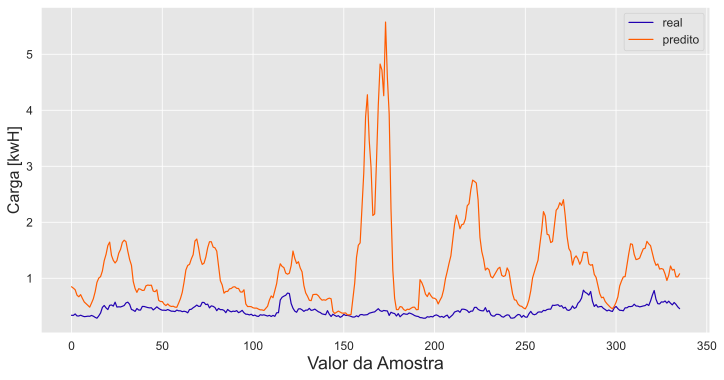

In [104]:
fig = plt.figure()

sns.lineplot(data = df_out_teste2, x=df_out_teste2.index, y="carga_real", label = 'real', color = 'xkcd:ultramarine')
sns.lineplot(data = df_pred_teste2, x=df_pred_teste2.index, y="carga_real",  label = 'predito', color = 'xkcd:bright orange')

# fig.suptitle('Consumo Registrado - Perfil Residencial', fontsize=20)
plt.xlabel('Valor da Amostra', fontsize=18)
plt.ylabel('Carga [kwH]', fontsize=16)
fig.savefig('C:/Users/vitmi/Desktop/TCC/Imagens/Resultados_res/pred2_Consumo_res.png')

In [105]:
print('MAPES GRNN Treinamento: \n') 
print('MAPE Validacao:  {:0.4f} \n'.format(MAPE_tre)) 
print('EMAX Validacao:  {:0.4f} \n'.format(EMAX_tre)) 
print('\n') 
print('MAPES GRNN Teste 1: \n') 
print('MAPE Teste 1:  {:0.4f} \n'.format(MAPE_te1)) 
print('EMAX Teste 1:  {:0.4f} \n'.format(EMAX_te1)) 
print('\n') 
print('MAPES GRNN Teste 2: \n') 
print('MAPE Teste 1:  {:0.4f} \n'.format(MAPE_te2)) 
print('EMAX Teste 1:  {:0.4f} \n'.format(EMAX_te2)) 

MAPES GRNN Treinamento: 

MAPE Validacao:  129.4753 

EMAX Validacao:  490.8199 



MAPES GRNN Teste 1: 

MAPE Teste 1:  139.7766 

EMAX Teste 1:  665.9324 



MAPES GRNN Teste 2: 

MAPE Teste 1:  53.0792 

EMAX Teste 1:  92.4674 



## GRNN Modificada - Modelo Comercial

In [106]:
spread = list(np.arange(100, 10000, 50) / 10000)
spread_min_mod = 100

MAPE_MIN_a_mod = np.zeros(np.size(spread))
MAPE_MIN_mod = 100

EMAX_MIN_a_mod = np.zeros(np.size(spread))
EMAX_MIN_mod = 100

for (i,j) in zip(spread, range(np.size(spread))):

    GRNN_com_mod = train_matrix(data_mod_com_tre_m, data_out_com_tre_m, i)

    x2 = pd.DataFrame(implementa_grnn_mod(GRNN_com_mod, data_mod_com_val_m, 50),\
                      index = data_out_com_val.index, columns = data_out_com_val.columns)

    df3 = ajeita_df(x2)
    df4 = ajeita_df(data_out_com_val)

    MAPE_MIN_a_mod[j] = mape(df4['carga'], df3['carga'])
    EMAX_MIN_a_mod[j] = emax(df4['carga'], df3['carga'])

    if(MAPE_MIN_a_mod[j] < MAPE_MIN_mod or EMAX_MIN_a_mod[j] < EMAX_MIN_mod ):
        MAPE_MIN_mod = MAPE_MIN_a_mod[j]
        EMAX_MIN_mod = EMAX_MIN_a_mod[j]
        spread_min_mod = i

In [107]:
spread_min_mod

0.995

In [108]:
%%time
GRNN_com_mod = train_matrix(data_mod_com_tre_m, data_out_com_tre_m, spread_min_mod)
    
x2 = pd.DataFrame(implementa_grnn_mod(GRNN_com_mod, data_mod_com_val_m, 50),\
                  index = data_out_com_val.index, columns = data_out_com_val.columns)


Wall time: 18 ms


In [109]:
df3 = ajeita_df(x2)
df4 = ajeita_df(data_out_com_val)
    
df3['carga_real'] = df3['carga']*max_comercial
df4['carga_real'] = df4['carga']*max_comercial

MAPE_te_mod = mape(df4['carga'], df3['carga'])
EMAX_te_mod = emax(df4['carga'], df3['carga'])


In [110]:
df1_val_1 = df3[(df3['data_med'] == '2018-12-01')]
df1_val_2 = df3[(df3['data_med'] == '2018-12-02')]
df1_val_3 = df3[(df3['data_med'] == '2018-12-03')]
df1_val_4 = df3[(df3['data_med'] == '2018-12-04')]
df1_val_5 = df3[(df3['data_med'] == '2018-12-05')]
df1_val_6 = df3[(df3['data_med'] == '2018-12-06')]
df1_val_7 = df3[(df3['data_med'] == '2018-12-07')]

df2_val_1 = df4[(df4['data_med'] == '2018-12-01')]
df2_val_2 = df4[(df4['data_med'] == '2018-12-02')]
df2_val_3 = df4[(df4['data_med'] == '2018-12-03')]
df2_val_4 = df4[(df4['data_med'] == '2018-12-04')]
df2_val_5 = df4[(df4['data_med'] == '2018-12-05')]
df2_val_6 = df4[(df4['data_med'] == '2018-12-06')]
df2_val_7 = df4[(df4['data_med'] == '2018-12-07')]

mape_val_1 = mape(df2_val_1['carga_real'], df1_val_1['carga_real'])
mape_val_2 = mape(df2_val_2['carga_real'], df1_val_2['carga_real'])
mape_val_3 = mape(df2_val_3['carga_real'], df1_val_3['carga_real'])
mape_val_4 = mape(df2_val_4['carga_real'], df1_val_4['carga_real'])
mape_val_5 = mape(df2_val_5['carga_real'], df1_val_5['carga_real'])
mape_val_6 = mape(df2_val_6['carga_real'], df1_val_6['carga_real'])
mape_val_7 = mape(df2_val_7['carga_real'], df1_val_7['carga_real'])

print('MAPES GRNN: \n') 
print('{:0.2f}'.format(mape_val_1)) 
print('{:0.2f}'.format(mape_val_2))
print('{:0.2f}'.format(mape_val_3)) 
print('{:0.2f}'.format(mape_val_4)) 
print('{:0.2f}'.format(mape_val_5)) 
print('{:0.2f}'.format(mape_val_6)) 
print('{:0.2f}'.format(mape_val_7)) 

MAPES GRNN: 

106.36
105.57
160.19
115.61
155.29
120.45
116.24


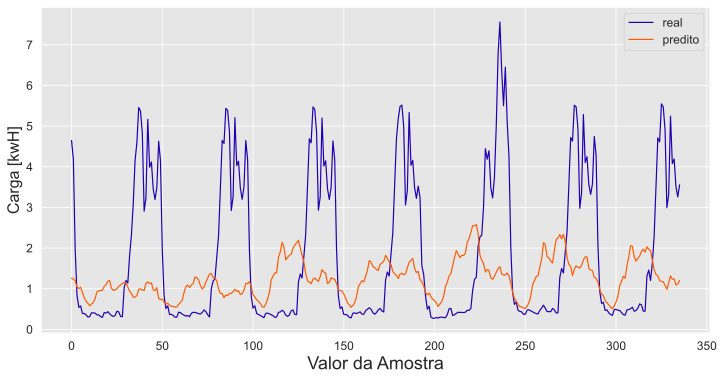

In [111]:
fig = plt.figure()

sns.lineplot(data = df4, x=df4.index, y="carga_real", label = 'real', color = 'xkcd:ultramarine')
sns.lineplot(data = df3, x=df3.index, y="carga_real",  label = 'predito', color = 'xkcd:bright orange')

# fig.suptitle('Consumo Registrado - Perfil Residencial', fontsize=20)
plt.xlabel('Valor da Amostra', fontsize=18)
plt.ylabel('Carga [kwH]', fontsize=16)
fig.savefig('C:/Users/vitmi/Desktop/TCC/Imagens/Resultados_res/tr2_Consumo_res.png')

### Teste - GRNN Modificada - Modelo Comercial

In [112]:
%%time
result_teste1_mod = teste_grnn(testes_input_1, out1, columns_n_1, GRNN_com_mod)

Wall time: 120 ms


In [113]:
df_pred_teste1_mod = ajeita_df(result_teste1_mod)
df_out_teste1_mod = ajeita_df(data_out_com_teste1)

df_pred_teste1_mod['carga_real'] = df_pred_teste1_mod['carga']*max_comercial
df_out_teste1_mod['carga_real'] = df_out_teste1_mod['carga']*max_comercial

MAPE_te1_mod = mape(df_pred_teste1_mod['carga'], df_out_teste1_mod['carga'])
EMAX_te1_mod = emax(df_pred_teste1_mod['carga'], df_out_teste1_mod['carga'])

In [114]:
df1_val_1 = df_pred_teste1_mod[(df_pred_teste1_mod['data_med'] == '2018-12-08')]
df1_val_2 = df_pred_teste1_mod[(df_pred_teste1_mod['data_med'] == '2018-12-09')]
df1_val_3 = df_pred_teste1_mod[(df_pred_teste1_mod['data_med'] == '2018-12-10')]
df1_val_4 = df_pred_teste1_mod[(df_pred_teste1_mod['data_med'] == '2018-12-11')]
df1_val_5 = df_pred_teste1_mod[(df_pred_teste1_mod['data_med'] == '2018-12-12')]
df1_val_6 = df_pred_teste1_mod[(df_pred_teste1_mod['data_med'] == '2018-12-13')]
df1_val_7 = df_pred_teste1_mod[(df_pred_teste1_mod['data_med'] == '2018-12-14')]

df2_val_1 = df_out_teste1_mod[(df_out_teste1_mod['data_med'] == '2018-12-08')]
df2_val_2 = df_out_teste1_mod[(df_out_teste1_mod['data_med'] == '2018-12-09')]
df2_val_3 = df_out_teste1_mod[(df_out_teste1_mod['data_med'] == '2018-12-10')]
df2_val_4 = df_out_teste1_mod[(df_out_teste1_mod['data_med'] == '2018-12-11')]
df2_val_5 = df_out_teste1_mod[(df_out_teste1_mod['data_med'] == '2018-12-12')]
df2_val_6 = df_out_teste1_mod[(df_out_teste1_mod['data_med'] == '2018-12-13')]
df2_val_7 = df_out_teste1_mod[(df_out_teste1_mod['data_med'] == '2018-12-14')]

mape_val_1 = mape(df2_val_1['carga_real'], df1_val_1['carga_real'])
mape_val_2 = mape(df2_val_2['carga_real'], df1_val_2['carga_real'])
mape_val_3 = mape(df2_val_3['carga_real'], df1_val_3['carga_real'])
mape_val_4 = mape(df2_val_4['carga_real'], df1_val_4['carga_real'])
mape_val_5 = mape(df2_val_5['carga_real'], df1_val_5['carga_real'])
mape_val_6 = mape(df2_val_6['carga_real'], df1_val_6['carga_real'])
mape_val_7 = mape(df2_val_7['carga_real'], df1_val_7['carga_real'])

print('MAPES GRNN: \n') 
print('{:0.2f}'.format(mape_val_1)) 
print('{:0.2f}'.format(mape_val_2))
print('{:0.2f}'.format(mape_val_3)) 
print('{:0.2f}'.format(mape_val_4)) 
print('{:0.2f}'.format(mape_val_5)) 
print('{:0.2f}'.format(mape_val_6)) 
print('{:0.2f}'.format(mape_val_7)) 

MAPES GRNN: 

118.74
107.75
120.33
122.46
110.71
117.48
88.03


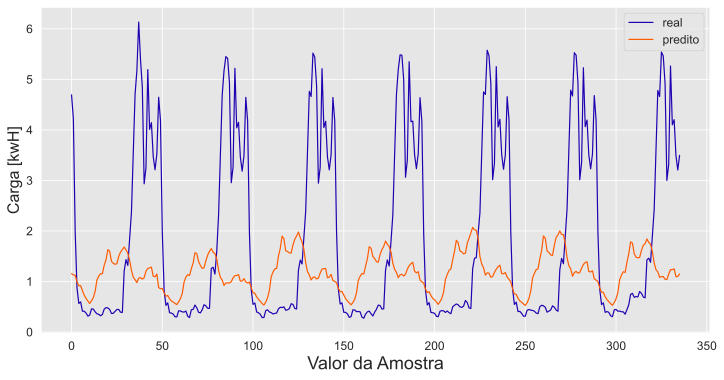

In [115]:
fig = plt.figure()

sns.lineplot(data = df_out_teste1_mod, x=df_out_teste1_mod.index, y="carga_real", label = 'real', color = 'xkcd:ultramarine')
sns.lineplot(data = df_pred_teste1_mod, x=df_pred_teste1_mod.index, y="carga_real",  label = 'predito', color = 'xkcd:bright orange')

# fig.suptitle('Consumo Registrado - Perfil Residencial', fontsize=20)
plt.xlabel('Valor da Amostra', fontsize=18)
plt.ylabel('Carga [kwH]', fontsize=16)
fig.savefig('C:/Users/vitmi/Desktop/TCC/Imagens/Resultados_res/pred1_mod_Consumo_res.png')

In [116]:
%%time
result_teste2_mod = teste_grnn(testes_input_2, out2, columns_n_2, GRNN_com_mod)

Wall time: 117 ms


In [117]:
df_pred_teste2_mod = ajeita_df(result_teste2_mod)
df_out_teste2_mod = ajeita_df(data_out_com_teste2)

df_pred_teste2_mod['carga_real'] = df_pred_teste2_mod['carga']*max_comercial
df_out_teste2_mod['carga_real'] = df_out_teste2_mod['carga']*max_comercial

MAPE_te2_mod = mape(df_pred_teste2_mod['carga'], df_out_teste2_mod['carga'])
EMAX_te2_mod = emax(df_pred_teste2_mod['carga'], df_out_teste2_mod['carga'])

In [118]:
MAPE_te2_mod

58.97224562516881

In [119]:
df1_val_1 = df_pred_teste2_mod[(df_pred_teste2_mod['data_med'] == '2018-12-22')]
df1_val_2 = df_pred_teste2_mod[(df_pred_teste2_mod['data_med'] == '2018-12-23')]
df1_val_3 = df_pred_teste2_mod[(df_pred_teste2_mod['data_med'] == '2018-12-24')]
df1_val_4 = df_pred_teste2_mod[(df_pred_teste2_mod['data_med'] == '2018-12-25')]
df1_val_5 = df_pred_teste2_mod[(df_pred_teste2_mod['data_med'] == '2018-12-26')]
df1_val_6 = df_pred_teste2_mod[(df_pred_teste2_mod['data_med'] == '2018-12-27')]
df1_val_7 = df_pred_teste2_mod[(df_pred_teste2_mod['data_med'] == '2018-12-28')]

df2_val_1 = df_out_teste2_mod[(df_out_teste2_mod['data_med'] == '2018-12-22')]
df2_val_2 = df_out_teste2_mod[(df_out_teste2_mod['data_med'] == '2018-12-23')]
df2_val_3 = df_out_teste2_mod[(df_out_teste2_mod['data_med'] == '2018-12-24')]
df2_val_4 = df_out_teste2_mod[(df_out_teste2_mod['data_med'] == '2018-12-25')]
df2_val_5 = df_out_teste2_mod[(df_out_teste2_mod['data_med'] == '2018-12-26')]
df2_val_6 = df_out_teste2_mod[(df_out_teste2_mod['data_med'] == '2018-12-27')]
df2_val_7 = df_out_teste2_mod[(df_out_teste2_mod['data_med'] == '2018-12-28')]

mape_val_1 = mape(df2_val_1['carga_real'], df1_val_1['carga_real'])
mape_val_2 = mape(df2_val_2['carga_real'], df1_val_2['carga_real'])
mape_val_3 = mape(df2_val_3['carga_real'], df1_val_3['carga_real'])
mape_val_4 = mape(df2_val_4['carga_real'], df1_val_4['carga_real'])
mape_val_5 = mape(df2_val_5['carga_real'], df1_val_5['carga_real'])
mape_val_6 = mape(df2_val_6['carga_real'], df1_val_6['carga_real'])
mape_val_7 = mape(df2_val_7['carga_real'], df1_val_7['carga_real'])

print('MAPES GRNN: \n') 
print('{:0.2f}'.format(mape_val_1)) 
print('{:0.2f}'.format(mape_val_2))
print('{:0.2f}'.format(mape_val_3)) 
print('{:0.2f}'.format(mape_val_4)) 
print('{:0.2f}'.format(mape_val_5)) 
print('{:0.2f}'.format(mape_val_6)) 
print('{:0.2f}'.format(mape_val_7)) 

MAPES GRNN: 

154.68
139.39
135.64
278.39
237.20
179.89
131.00


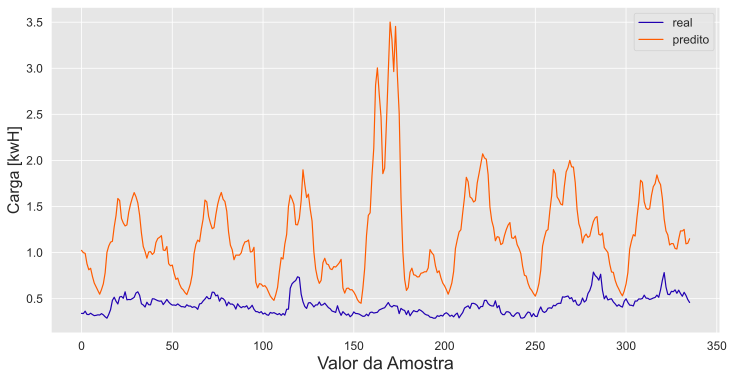

In [120]:
fig = plt.figure()

sns.lineplot(data = df_out_teste2_mod, x=df_out_teste2_mod.index, y="carga_real", label = 'real', color = 'xkcd:ultramarine')
sns.lineplot(data = df_pred_teste2_mod, x=df_pred_teste2_mod.index, y="carga_real",  label = 'predito', color = 'xkcd:bright orange')

# fig.suptitle('Consumo Registrado - Perfil Residencial', fontsize=20)
plt.xlabel('Valor da Amostra', fontsize=18)
plt.ylabel('Carga [kwH]', fontsize=16)
fig.savefig('C:/Users/vitmi/Desktop/TCC/Imagens/Resultados_res/pred2_mod_Consumo_res.png')

In [121]:
print('Medidas GRNN Treinamento: \n') 
print('MAPE Validacao:  {:0.4f} \n'.format(MAPE_te_mod)) 
print('EMAX Validacao:  {:0.4f} \n'.format(EMAX_te_mod)) 
print('\n') 
print('Medidas GRNN Modificada - Teste 1: \n') 
print('MAPE Teste 1:  {:0.4f} \n'.format(MAPE_te1_mod)) 
print('EMAX Teste 1:  {:0.4f} \n'.format(EMAX_te1_mod)) 
print('\n') 
print('Medidas GRNN Modificada - Teste 2: \n') 
print('MAPE Teste 1:  {:0.4f} \n'.format(MAPE_te2_mod)) 
print('EMAX Teste 1:  {:0.4f} \n'.format(EMAX_te2_mod)) 

Medidas GRNN Treinamento: 

MAPE Validacao:  125.6728 

EMAX Validacao:  486.3847 



Medidas GRNN Modificada - Teste 1: 

MAPE Teste 1:  127.6482 

EMAX Teste 1:  475.4057 



Medidas GRNN Modificada - Teste 2: 

MAPE Teste 1:  58.9722 

EMAX Teste 1:  88.3254 



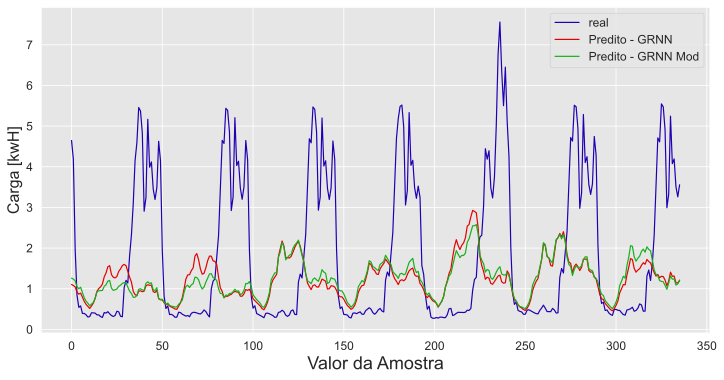

In [122]:
fig = plt.figure()

sns.lineplot(data = df2, x=df2.index, y="carga_real", label = 'real', color = 'xkcd:ultramarine')
sns.lineplot(data = df1, x=df1.index, y="carga_real",  label = 'Predito - GRNN', color = 'xkcd:red')
sns.lineplot(data = df3, x=df3.index, y="carga_real",  label = 'Predito - GRNN Mod', color = 'xkcd:green')
# fig.suptitle('Consumo Registrado - Perfil Residencial', fontsize=20)
plt.xlabel('Valor da Amostra', fontsize=18)
plt.ylabel('Carga [kwH]', fontsize=16)
fig.savefig('C:/Users/vitmi/Desktop/TCC/Imagens/Resultados_res_final/tr_Consumo_res.png')



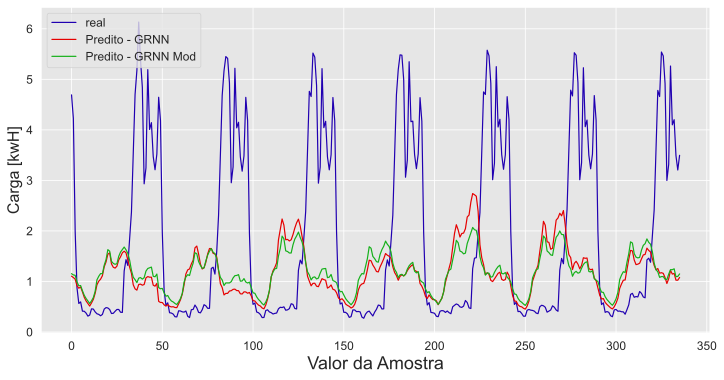

In [123]:
fig = plt.figure()

sns.lineplot(data = df_out_teste1, x=df_out_teste1.index, y="carga_real", label = 'real', color = 'xkcd:ultramarine')
sns.lineplot(data = df_pred_teste1, x=df_pred_teste1.index, y="carga_real",  label = 'Predito - GRNN', color = 'xkcd:red')
sns.lineplot(data = df_pred_teste1_mod, x=df_pred_teste1_mod.index, y="carga_real",  label = 'Predito - GRNN Mod', color = 'xkcd:green')
# fig.suptitle('Consumo Registrado - Perfil Residencial', fontsize=20)
plt.xlabel('Valor da Amostra', fontsize=18)
plt.ylabel('Carga [kwH]', fontsize=16)
fig.savefig('C:/Users/vitmi/Desktop/TCC/Imagens/Resultados_res_final/pred1_Consumo_res.png')


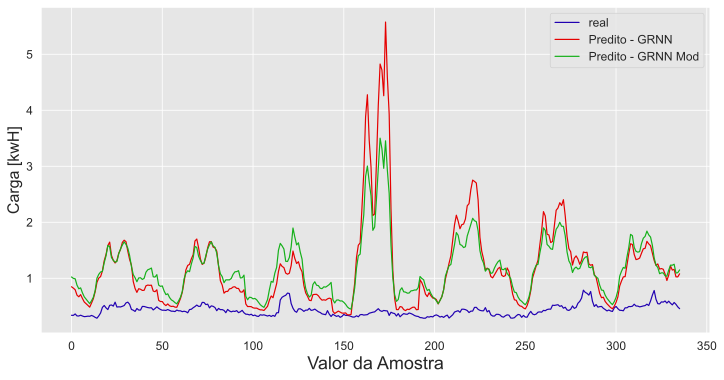

In [124]:
fig = plt.figure()

sns.lineplot(data = df_out_teste2, x=df_out_teste2.index, y="carga_real", label = 'real', color = 'xkcd:ultramarine')
sns.lineplot(data = df_pred_teste2, x=df_pred_teste2.index, y="carga_real",  label = 'Predito - GRNN', color = 'xkcd:red')
sns.lineplot(data = df_pred_teste2_mod, x=df_pred_teste2_mod.index, y="carga_real",  label = 'Predito - GRNN Mod', color = 'xkcd:green')
# fig.suptitle('Consumo Registrado - Perfil Residencial', fontsize=20)
plt.xlabel('Valor da Amostra', fontsize=18)
plt.ylabel('Carga [kwH]', fontsize=16)
fig.savefig('C:/Users/vitmi/Desktop/TCC/Imagens/Resultados_res_final/pred2_Consumo_res.png')
